In [89]:
import re
import tqdm
from nltk.corpus import stopwords
import nltk
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_addons as tfa
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

In [90]:
# read data
df = pd.read_csv("raw_data/fulltrain.csv", names=["labels", "text"])
df.head()

,labels,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48854 entries, 0 to 48853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  48854 non-null  int64 
 1   text    48854 non-null  object
dtypes: int64(1), object(1)
memory usage: 763.5+ KB


In [92]:
# create x and y
x = df["text"]

# transform y into one hot vectors
y = pd.get_dummies(df["labels"])
y = np.array(y)

In [93]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [94]:
# set constants
MAX_NB_WORDS = 100000 # max number of words for tokenizer TODO: double check with this dataset
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding TODO: double check for this dataset supposed to be 131926
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 300 # embedding dimensions for word vectors
GLOVE_DIR = f"glove/glove.6B.{EMBEDDING_DIM}d.txt"


In [29]:
# find the max number of tokens in a single row: answer = 131926 
# Don't run if not needed
recalculate = False
if recalculate: 
    maxLen = 0
    for sentence in x: 
        tokens = nltk.word_tokenize(sentence)
        maxLen = max(maxLen, len(tokens))
    print(maxLen)

131926


In [95]:
# sentence cleaning
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
    text = str(text).replace(r'\.\.+','.') #replace multiple periods with a single one
    text = str(text).replace(r'\.',' . ') # replace periods with a single one
    text = str(text).replace(r'\s\s+',' ') #replace multiple white space with a single one
    text = str(text).replace("\n", "") #removing line breaks
    text = re.sub(r'[^\w\s]','',text).lower() #lower texts
    if remove_stopwords:
        text = text.split(" ")

    for word in text:
        if word not in stopwords.words("english"):
            output = f"{output} {word}"
    return output.strip()

In [96]:
clean_text("the quick brown fox.. Help me so! create in my. chicken")

'quick brown fox help create chicken'

In [97]:
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/maxx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [100]:
# remove stopwords from x

import os 
# check if "texts_cleaned.csv" exists
if not os.path.exists("texts_cleaned.csv"):
    texts = []
    counter = 0
    
    print(f"total of {len(x)} lines")
    output = pd.DataFrame()
    for line in x: 
        texts.append(clean_text(line))

        if len(texts) % 100 == 0: 
            counter += 100
            print(f"cleaned {counter} lines")
            
            temp_df = pd.DataFrame({"texts": texts})
            # concat with output dataframe
            output = pd.concat([output, temp_df], ignore_index=True)
            texts = []

    output.to_csv("texts_cleaned.csv", index=False)

clean_text_df = pd.read_csv("texts_cleaned.csv")
texts = clean_text_df["texts"]

In [101]:
# tokenize
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

Vocabulary size: 323792


In [102]:
# pad data so they are uniform

data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print(f"Shape of data tensor: {data.shape}")
print(f"Shape of label tensor: {y.shape}")

Shape of data tensor: (48800, 1000)
Shape of label tensor: (48854, 4)


In [103]:
# shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]


In [104]:
# split data
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print("Number of entries in each category:")
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [11302  5555 14278  7905]
validation:  [2745 1387 3592 2036]


In [105]:
# create embedding matrix
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf8')
print(f"Loading Glove from: {GLOVE_DIR}")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Completed!")

Loading Glove from: glove/glove.6B.300d.txt
Done.
 Proceeding with Embedding Matrix...
Completed!


In [106]:
# create model
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable=False,
    name = 'embeddings'))
model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation="softmax"))

In [116]:
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics = [
        "categorical_accuracy", 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_score_micro"), 
        tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro")
    ]
)

In [117]:
history = model.fit(x_train, y_train, epochs = 10, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/10


2023-03-29 14:22:16.164936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 14:22:16.999492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 14:22:22.642972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


305/305 [==============================] - ETA: 0s - loss: 0.5223 - categorical_accuracy: 0.8067 - precision_3: 0.8972 - recall_3: 0.7078 - auc_1: 0.9558 - f1_score_micro: 0.8067 - f1_score_macro: 0.7904

2023-03-29 14:25:00.884492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 14:25:01.090791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


305/305 [==============================] - 193s 554ms/step - loss: 0.5223 - categorical_accuracy: 0.8067 - precision_3: 0.8972 - recall_3: 0.7078 - auc_1: 0.9558 - f1_score_micro: 0.8067 - f1_score_macro: 0.7904 - val_loss: 0.2149 - val_categorical_accuracy: 0.9253 - val_precision_3: 0.9384 - val_recall_3: 0.9159 - val_auc_1: 0.9916 - val_f1_score_micro: 0.9253 - val_f1_score_macro: 0.9191
Epoch 2/10
305/305 [==============================] - 162s 529ms/step - loss: 0.1941 - categorical_accuracy: 0.9332 - precision_3: 0.9422 - recall_3: 0.9248 - auc_1: 0.9930 - f1_score_micro: 0.9332 - f1_score_macro: 0.9272 - val_loss: 0.1599 - val_categorical_accuracy: 0.9452 - val_precision_3: 0.9525 - val_recall_3: 0.9382 - val_auc_1: 0.9949 - val_f1_score_micro: 0.9452 - val_f1_score_macro: 0.9404
Epoch 3/10
305/305 [==============================] - 162s 530ms/step - loss: 0.1306 - categorical_accuracy: 0.9546 - precision_3: 0.9597 - recall_3: 0.9497 - auc_1: 0.9966 - f1_score_micro: 0.9546 - f1_

In [118]:
model.save('lstm_model')

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


In [119]:
results = model.evaluate(x_val, y_val, batch_size=128)
print('Test loss:', results[0])
print('Test categorical_accuracy:', results[1])
print('Test precision:', results[2])
print('Test recall:', results[3])
print('Test auc:', results[4])
print('Test F1 (micro):', results[5])
print('Test F1 (macro):', results[6])

77/77 [==============================] - 18s 233ms/step - loss: 0.1064 - categorical_accuracy: 0.9701 - precision_3: 0.9706 - recall_3: 0.9693 - auc_1: 0.9961 - f1_score_micro: 0.9701 - f1_score_macro: 0.9681
Test loss: 0.10643189400434494
Test categorical_accuracy: 0.9700819849967957
Test precision: 0.9705550670623779
Test recall: 0.9692623019218445
Test auc: 0.9960734844207764
Test F1 (micro): 0.9700820446014404
Test F1 (macro): 0.9680694341659546


In [121]:
predictions = model.predict(x_val, batch_size=128)
result = np.argmax(predictions, axis=1)

2023-03-29 14:52:15.882738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 14:52:15.964143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 25s 267ms/step


In [122]:
result.shape

(9760,)

In [123]:
x_val.shape

(9760, 1000)

In [132]:
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from PIL import Image 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [133]:
def draw_confusion_matrix(true, preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(
        conf_matx, 
        annot=True, 
        annot_kws={"size": 12},
        fmt='g', 
        cbar=False, 
        cmap="viridis"
    )
    plt.show()

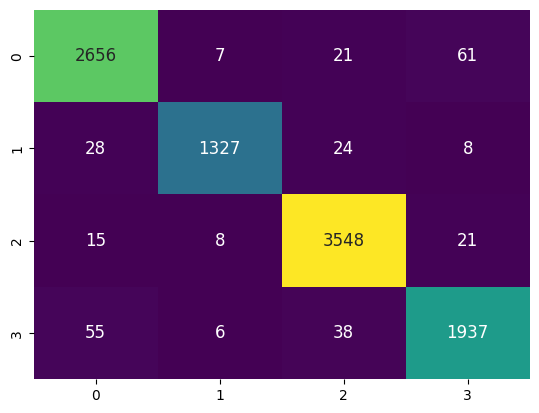

In [135]:
draw_confusion_matrix(np.argmax(y_val, axis=1), result)

START Cleaning text
DONE Cleaning text
START tokenize
DONE tokenize
START predict
94/94 [==============================] - 24s 253ms/step
DONE predict
START evaluate
24/24 [==============================] - 10s 408ms/step - loss: 3.6042 - categorical_accuracy: 0.3613 - precision_3: 0.3646 - recall_3: 0.3513 - auc_1: 0.6033 - f1_score_micro: 0.3613 - f1_score_macro: 0.2872
Test loss: 3.6042470932006836
Test categorical_accuracy: 0.36133334040641785
Test precision: 0.3645797371864319
Test recall: 0.3513333201408386
Test auc: 0.6032506227493286
Test F1 (micro): 0.36133334040641785
Test F1 (macro): 0.2871997058391571


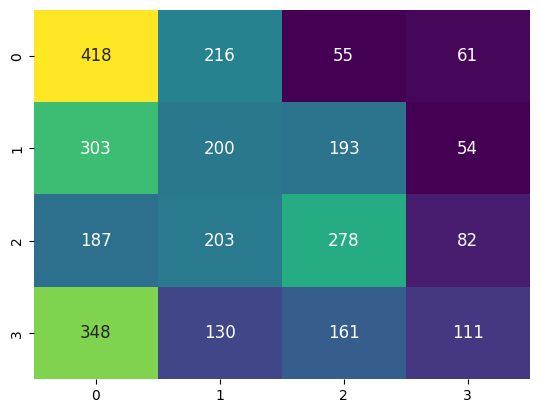

In [138]:
# test on balanced test.csv
test_df = pd.read_csv("raw_data/balancedtest.csv", names=["labels", "text"])

# clean text
print("START Cleaning text")
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
print("DONE Cleaning text")

# split into x_test and y_test
x_test = test_df['cleaned_text']

# transform y into one hot vectors
y_test = pd.get_dummies(test_df["labels"])
y_test = np.array(y_test)

# tokenize
print("START tokenize")
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(x_test)
test_sequences = test_tokenizer.texts_to_sequences(x_test)
word_index = test_tokenizer.word_index
test_data_padded = pad_sequences(test_sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print("DONE tokenize")



START predict
94/94 [==============================] - 20s 208ms/step
DONE predict
START evaluate
94/94 [==============================] - 25s 264ms/step - loss: 5.1981 - categorical_accuracy: 0.3357 - precision_3: 0.3377 - recall_3: 0.3300 - auc_1: 0.5816 - f1_score_micro: 0.3357 - f1_score_macro: 0.3201
Test loss: 5.198129653930664
Test categorical_accuracy: 0.3356666564941406
Test precision: 0.3376534879207611
Test recall: 0.32999998331069946
Test auc: 0.5815756320953369
Test F1 (micro): 0.3356666564941406
Test F1 (macro): 0.320085346698761


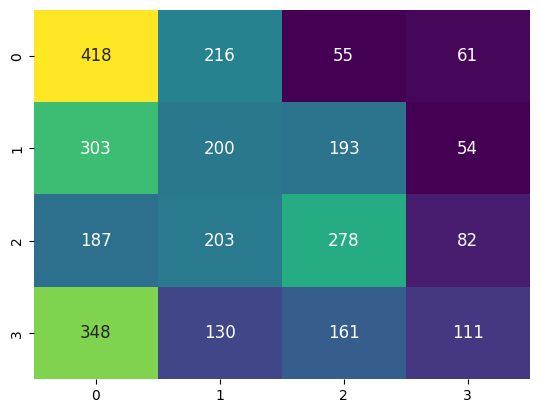

In [140]:
# predict
print("START predict")
test_predictions = model.predict(test_data_padded)
test_result = np.argmax(test_predictions, axis=1)
print("DONE predict")

# evaluate
print("START evaluate")
test_results = model.evaluate(test_data_padded, y_test)
print('Test loss:', test_results[0])
print('Test categorical_accuracy:', test_results[1])
print('Test precision:', test_results[2])
print('Test recall:', test_results[3])
print('Test auc:', test_results[4])
print('Test F1 (micro):', test_results[5])
print('Test F1 (macro):', test_results[6])

draw_confusion_matrix(np.argmax(y_test, axis=1), test_result)